In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.special import expit
from numpy.linalg import inv
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve
from sklearn import metrics
from numpy.linalg import inv
np.random.seed(123)

In [2]:
def init(size=50):
    X_1 = np.random.uniform(low=0,high=3,size=size)
    X_2 = np.random.uniform(low=0,high=3,size=size)
    Y = [np.random.binomial(n=1, p=(1/(1+math.exp(-1*(-3+X_1[i]+X_2[i]))))) for i in range(0,size)]
    theta = np.zeros(3).T
    return np.array([X_1,X_2]).reshape(2,-1),np.array(Y).reshape(-1,1), theta

In [3]:
class GradientDescent():
 
    #  Batch Gradient Descent Logistic.
    def bgd(self, theta, x, y, learning_rate=0.001, num_steps=10):
        m = len(x)
        x= np.insert(x, 0, 1, axis=0).T
        error = []
        for i in range(0, num_steps):
            error.append((-1/50)*np.sum(((y*np.log(expit(theta * x)))+(1-y)*np.log(1-expit(theta*x)))))
            theta = theta - (learning_rate * (np.dot((expit(np.sum(theta*x, axis=1))-y).T, x)/m))[0]
        self.theta = theta
        return theta, error    
    
    # SGD Logistic
    def sgd(self,theta, x, y, learning_rate=0.08, num_steps=23):
        m = len(x.T)
        x= np.insert(x, 0, 1, axis=0).T
        index = np.arange(m)
        np.random.shuffle(index)
        x = x[index]
        y = y[index]
        error = []
        for i in range(0, num_steps):
            error.append((-1/50)*np.sum(((y*np.log(expit(theta * x)))+(1-y)*np.log(1-expit(theta*x)))))
            for j in range(0,m):
                theta = theta - (learning_rate * (((np.multiply(expit(np.sum(theta * x[j])) - y[j], x[j]) /m))))
        self.theta = theta
        return theta, error
    
    # LDA
    def lda(self, x, y, x_val, y_val):
        x = x.T
        x_val = x_val.T
        cov = inv(np.cov(x, rowvar=False))
        pie0 = len(y[np.where(y == 0)])/ len(y)
        pie1 = len(y[np.where(y == 1)])/ len(y)
        mu0= np.mean(x[np.where(y==0)[0], :], axis=0)
        mu1 = np.mean(x[np.where(y==1)[0], :], axis=0)
        p0 = np.dot(np.dot(x , cov), mu0) - (0.5*np.dot(mu0.T, np.dot(cov, mu0))) + np.log(pie0)
        p1 = np.dot(np.dot(x , cov), mu1) - (0.5*np.dot(mu1.T, np.dot(cov, mu1))) + np.log(pie1)
        pred = np.where(p0 > p1, 0, 1)
        decision = ((0.5*np.dot((mu0-mu1).T, np.dot(cov, (mu0-mu1)))) - np.log(pie0/pie1)) / np.dot(cov, (mu0-mu1))
        return metrics.accuracy_score(y_val, pred), (-1*decision)
        
    
    # Predicting the accuracy
    def predict_score(self, true_y,x, threshold=0.5):
        x= np.insert(x, 0, 1, axis=0).T
        y = [1 if i > threshold else 0 for i in expit(np.sum(self.theta*x, axis=1)) ]
        return metrics.accuracy_score(true_y,y)

In [4]:
def pltHist(steps, style):
    score = []
    for i in range(0, steps):
        X_train, Y_train, theta_train = init()
        X_val, Y_val, theta_val = init()
        gd = GradientDescent() 
        if style == 'gd':
            _, _ = gd.bgd(theta_train, X_train, Y_train, learning_rate=0.08, num_steps=1000)
            score.append(gd.predict_score(Y_val,X_val))
        elif style == 'sgd':
            _,_ = gd.sgd(theta_train, X_train, Y_train, learning_rate=0.08, num_steps=1000)
            score.append(gd.predict_score(Y_val,X_val))
        elif style == 'lda':
            sc, _ = gd.lda(X_train, Y_train, X_val, Y_val)
            score.append(sc)
        del gd
    print('The mean acc is :', np.mean(score))
    plt.title('Score-Value Histogram for ' + style)
    plt.xlabel('% Acc')
    plt.hist(score)
    plt.show()
    return score

In [5]:
X_train, Y_train, theta_train = init()
X_val, Y_val, theta_train = init()
gd = GradientDescent()
bgd_theta, _ = gd.bgd(theta_train, X_train, Y_train, learning_rate=0.08, num_steps=1000)
bgd_score = gd.predict_score(Y_val,X_val)
sgd_theta, _ = gd.sgd(theta_train, X_train, Y_train, learning_rate=0.08, num_steps=1000)
sgd_score = gd.predict_score(Y_val,X_val)
sc, X_2_lda = gd.lda(X_train, Y_train, X_val, Y_val)
colors = np.where(Y_train == 0, 'black', 'm')

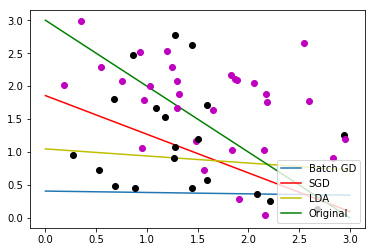

In [6]:
X_1 = np.array([0.0, 3.0])
X_2_bdg = -(bgd_theta[0] + X_1 * bgd_theta[1]) / bgd_theta[2]
X_2_sdg = -(sgd_theta[0] + X_1 * sgd_theta[1]) / sgd_theta[2]
X_2 = -(-3 + X_1 * 1)
plt.plot(X_1, X_2_bdg, label='Batch GD')
plt.plot(X_1, X_2_sdg, 'r', label= 'SGD')
plt.plot(X_1, X_2_lda, 'y', label='LDA')
plt.plot(X_1, X_2, 'g', label='Original')
for xy,c in zip(X_train.T,colors):
    plt.plot(xy[0], xy[1], 'o', color=c[0], picker=True)
plt.legend(loc='lower right')
plt.show()

The descision boundary of Batch GD Logistic model is almost a straight line. The LDA model shows poor slope however the Logistic SGD model show an identical slope to the original decision boundry. According to this SGD Logistic regression performs the best given this type of data. The slope and the direction is the same of that of original boundry only the 'stepness' of slope is different

The mean acc is : 0.5869


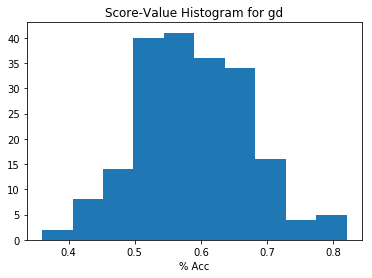

The mean acc is : 0.6827000000000001


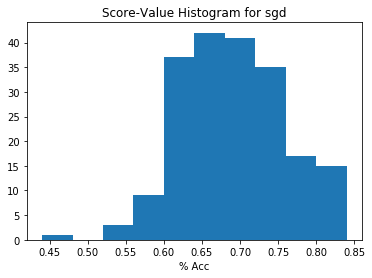

The mean acc is : 0.5003


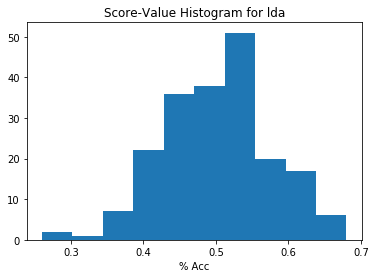

In [7]:
score_gd = pltHist(200, 'gd')
score_sgd = pltHist(200, 'sgd')
score_lda = pltHist(200, 'lda')

SGD Logistic regression performs the best and gets the best decision boundry amongst the 3. There is a some what random distribution in the accuracy of LDA. The accuracy of BGD Logistic regression shows a normal distribution around the mean

## Case study  (LDA vs Logistic)

In [8]:
dataset = np.loadtxt("hw3_dataset.txt")
index = np.arange(len(dataset))
np.random.shuffle(index)
dataset = dataset[index]

In [9]:
dataset_norm = np.append(dataset,(dataset[:, 2:4]**2), 1)
dataset_norm[:, 2:4] = normalize(dataset_norm[:,2:4])
dataset_norm[:, 6:] = normalize(dataset_norm[:,6:])

In [10]:
temp_train_x = dataset_norm[:160, 2:]
temp_train_y = dataset_norm[:160, 1]

a) Partition the dataset into a training, development and a validation subsets of equal size, by randomly selecting rows in the dataset. Explore the training set: report one-variable summary statistics, two-variable summary statistics, and discuss your findings.

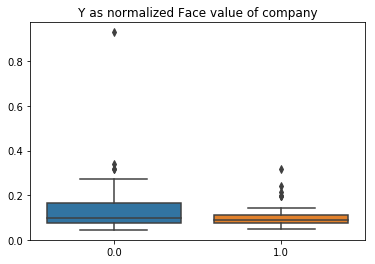

In [11]:
sns.boxplot(x=temp_train_y, y=temp_train_x[:, 1]).set_title('Y as normalized Face value of company')
plt.show()

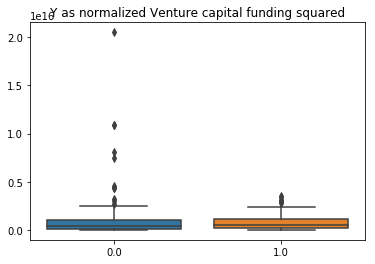

In [12]:
sns.boxplot(x=temp_train_y, y=temp_train_x[:, 3]).set_title('Y as normalized Venture capital funding squared')
plt.show()

The two variables seem to be showing more information than any other variables

In [13]:
def makeDataset(dataset,cols):
    train_x = dataset[:160, cols]
    train_y = dataset[:160, 1]
    dev_x = dataset[160:321, cols]
    dev_y = dataset[160:321, 1]
    val_x = dataset[321:, cols]
    val_y = dataset[321:, 1]
    return train_x, train_y, dev_x, dev_y, val_x, val_y

(b) Fit logistic regression on the training set. Consider transformations of variables, and the inclusion of higher-order terms if needed. Select the model with the best area under the ROC curve on the development set.
(c) Fit linear discriminant analysis on the training set. Consider transformations of variables, and the inclusion of higher-order terms if needed. Select the model with the best area under the ROC curve on the development set.

In [14]:
def fitModel(x, y):
    log = LogisticRegression()
    lda = LinearDiscriminantAnalysis()
    log.fit(train_x, train_y)
    lda.fit(train_x, train_y)
    print('Models fit')
    return log, lda

In [15]:
def plotROC(true, pred, lab):
    fpr, tpr, thresholds = roc_curve(true, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic ' + lab )
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Models fit


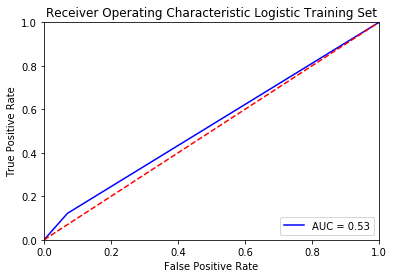

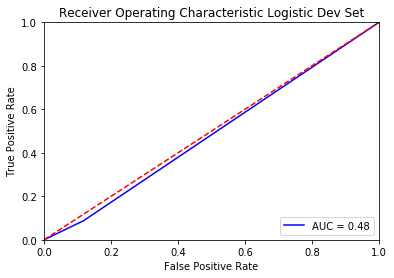

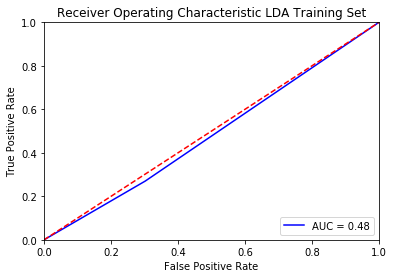

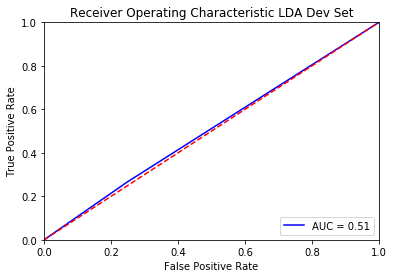

In [16]:
train_x, train_y, dev_x, dev_y, val_x, val_y = makeDataset(dataset_norm, [2,3,4])
log_1, lda_1 = fitModel(train_x, train_y)
plotROC(train_y, log_1.predict(train_x), 'Logistic Training Set')
plotROC(dev_y, log_1.predict(dev_x), 'Logistic Dev Set')
plotROC(train_y, lda_1.predict(train_x), 'LDA Training Set')
plotROC(dev_y, lda_1.predict(dev_x), 'LDA Dev Set')

Models fit


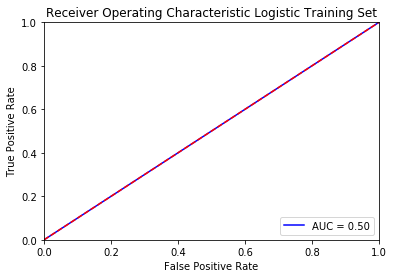

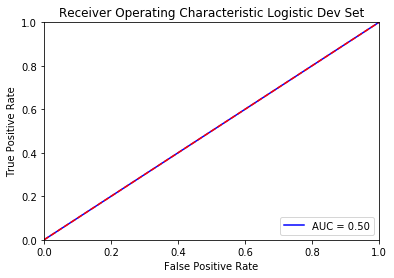

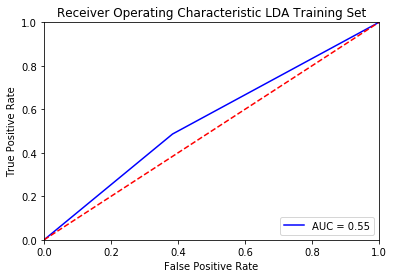

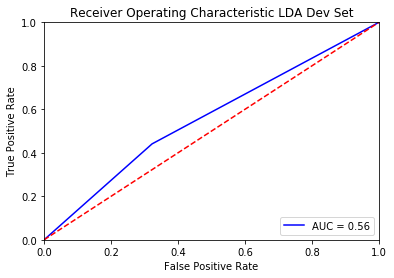

In [17]:
train_x, train_y, dev_x, dev_y, val_x, val_y = makeDataset(dataset_norm, [2,3,4,5,6])
log_2, lda_2 = fitModel(train_x, train_y)
plotROC(train_y, log_2.predict(train_x), 'Logistic Training Set')
plotROC(dev_y, log_2.predict(dev_x), 'Logistic Dev Set')
plotROC(train_y, lda_2.predict(train_x), 'LDA Training Set')
plotROC(dev_y, lda_2.predict(dev_x), 'LDA Dev Set')

The second model with more feautres perfrom much better and hence we select the second model

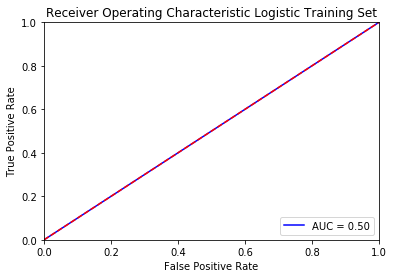

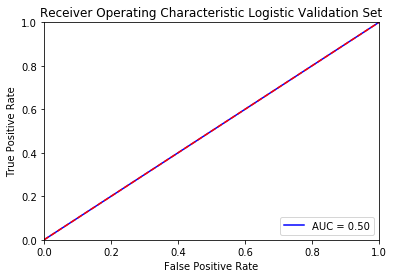

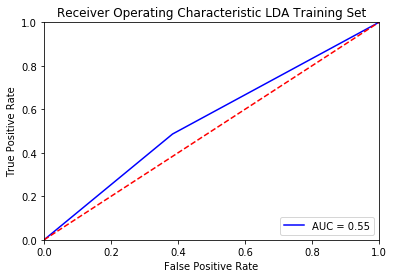

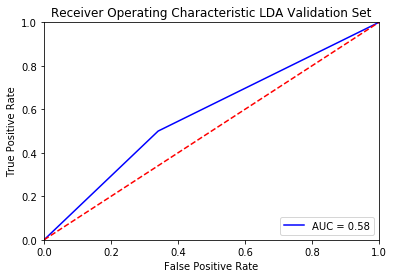

In [18]:
plotROC(train_y, log_2.predict(train_x), 'Logistic Training Set')
plotROC(val_y, log_2.predict(val_x), 'Logistic Validation Set')
plotROC(train_y, lda_2.predict(train_x), 'LDA Training Set')
plotROC(val_y, lda_2.predict(val_x), 'LDA Validation Set')

The result of Logistic regression is still 50% in validation set. There is a 3% accuracy increase in LDA validation set compared to training. LDA performs better over-all. The difference in perfromance is because LDA considers the spread and the distribution of X where as logistic doesn't. Models with more focus on how the data exists and how many parameters are there are more interpretable.